# 3 - Regression with Probabilistic Layers


Much of this material is adapted from the excellent blog post (Regression with Probabilistic Layers in TensorFlow Probability)[https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf], from the TensorFlow Probability team.

I'll walk through the problem formulation in order to get a handle on two types of uncertainty in machine learning problems and how TensorFlow Probability addresses each.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from pprint import pprint
from typing import Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import tensorflow as tf
from tensorflow.python import tf2
import tensorflow_probability as tfp


sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions
tf.get_logger().setLevel('ERROR')

We've seen how to solve regression problems in TensorFlow 2.0 -- now let's take it into TensorFlow Probability-land! TensorFlow Probability integrates in first-class fashion with TensorFlow 2.0 and allows us to define a model in TensorFlow and optimize it in order to solve a loss function -- like the typical Negative Log Likelihood.

In [2]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

Negative-Log Likelihood is an important function that's worth examining in some detail. Here, it means the likelihood that a given random observation occurs for some expected distribution of random observations, logged, and made negative. We can work through exactly why this is helpful as a distributional loss function.

In [3]:
np.log([0.01, 0.5, 0.9, 1, 1.5])

array([-4.60517019, -0.69314718, -0.10536052,  0.        ,  0.40546511])

We know that log increases monotonically increasing for numbers greater than 0, and we know the log of a value less than 1 will be negative. Fortunately, all probability likelihoods we encounter will be between 0 and 1.

For any TensorFlow Probability distribution, we can calculate the likelihood that a given observation or set of observations will occur.

In [4]:
tfd.Normal(loc=0, scale=1).prob(9)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0279782e-18>

In [5]:
tfd.Normal(loc=0, scale=1).prob([1, 2, 3, 4, 5]).numpy()

array([2.4197073e-01, 5.3990960e-02, 4.4318479e-03, 1.3383021e-04,
       1.4867194e-06], dtype=float32)

If we then log these values, so that the less likely observations have the more negative outputs, then take the additive inverse, then we have the makings of a smooth loss function.

In [6]:
np.log(tfd.Normal(loc=0, scale=1).prob(9).numpy())

-41.418938

In [7]:
np.log(tfd.Normal(loc=0, scale=1).prob(9).numpy()) * -1

41.41893768310547

In [8]:
negloglik(9, tfd.Normal(loc=0, scale=1)).numpy()

41.418938

In [9]:
negloglik(1, tfd.Normal(loc=0, scale=1)).numpy()

1.4189385

In [10]:
negloglik(-1, tfd.Normal(loc=0, scale=1)).numpy()

1.4189385

In [6]:
negloglik([100, 10, 1, 0, -1, -10, -100], tfd.Normal(loc=0, scale=1)).numpy()

array([5.0009189e+03, 5.0918938e+01, 1.4189385e+00, 9.1893852e-01,
       1.4189385e+00, 5.0918938e+01, 5.0009189e+03], dtype=float32)

This function has the nice property that it tells us how reasonable an observation is, given a probability distribution that we've defined. If we treat the data that we observe as _true_, then we can _learn_ a distribution that _minimizes_ the negative log likelihood across all observed distributions.

## Generate test data

For this problem, let's start from base principles and define our own data set from scratch. We're only going to be working on simple linear regression of **Y** given a one-dimensional **X**.

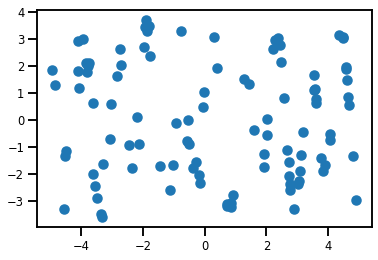

In [93]:
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Load a dataset of length n and a test dataset of length n_test."""
    np.random.seed(43)
    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)
    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    x = x[..., np.newaxis]
    x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
    x_tst = x_tst[..., np.newaxis]
    return y, x, x_tst

y, x, x_tst = load_dataset()

n = 100
x_func = np.linspace(-4,4,100)
y_func = x_func

x_train = np.random.uniform(-3, -2, n)
y_train = x_train + np.random.randn(*x_train.shape)*0.5

x_train = np.concatenate([x_train, np.random.uniform(2, 3, n)])
y_train = np.concatenate([y_train, x_train[n:] + np.random.randn(*x_train[n:].shape)*0.1])
x_test = np.linspace(-5,5,100)


x = x_train
y = y_train
x_tst = x_test[..., np.newaxis]


def generate_data(N=100):
    X = np.random.rand(N)[:, None] * 10 - 5  # Inputs, shape N x 1
    F = 2.5 * np.sin(6 * X) + np.cos(3 * X)  # Mean function values
    groups = np.where(X > 0, 0, 1)
    NoiseVar = np.array([0.02, 0.5])[groups]  # Different variances for the two groups
    Y = F + np.random.randn(N, 1) * np.sqrt(NoiseVar)  # Noisy data
    return X, Y, groups


X, Y, groups = generate_data()
plt.scatter(X,Y)

x = X
y = Y
x_tst = x_test[..., np.newaxis]

In [94]:
df = pd.DataFrame(x)
df['y'] = y
df.columns = ['x', 'y']

In [95]:
df.head()

,x,y
0,2.781192,-2.581425
1,3.123047,-1.273783
2,4.368448,3.168227
3,-2.729998,2.027076
4,-0.051940,0.496906


Let's take a look at what the relationship between these data looks like.

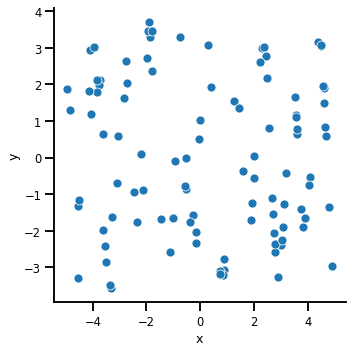

In [96]:
sns.relplot(x="x", y="y", data=df)

Seems linear enough -- let's build a linear regression model to test it out.

## Linear regression in TensorFlow Probability

In [97]:
class PrintDot(tf.keras.callbacks.Callback):
    """
    Display training progress by printing a single dot for 
    each completed epoch.
    """
    def on_epoch_end(self, epoch, logs) -> None:
        """
        `on_epoc_end` hook to take the epoch number and logs.
        This will run whenever the training loop finishes an epoch.
        """
        if epoch % 100 == 0: 
            print('')
        print('.', end='')


#  Note that we're explicitly modeling the output of our Dense layer as an input parameter to 
#  a TensorFlow Probability distribution.
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

Here, we've specified the Dense layer as outputting the mean of a Normal distribution that has a constant standard deviation of 1. This means that the neural network, rather than predicting the value of _x_ given _y_, is predicting the mean of a normal distribution whose standard deviation is 1, given _x_.

In [98]:
model.compile(optimizer=tf.optimizers.RMSprop(0.01), loss='mse')
history = model.fit(x, 
                    y, 
                    epochs=1000, 
                    validation_split=0.2,
                    verbose=0, 
                    callbacks=[PrintDot()]
                   )


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

By using our `tfp.layers` object in the definition of the model, we manage to create a TensorFlow Probability **Distribution** as our output of calling the model. Compare this to previously, when we simply got a NumPy Array object out.

In [99]:
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

TensorFlow Probability distributions have the nice feature that we can do statistical things on them, like draw samples.

In [100]:
tensor_draw = yhat.sample(1000)

In [101]:
tensor_draw.shape

TensorShape([1000, 100, 1])

So now we have 1,000 draws from each of the distributions learned for our 150 _x_'s. Let's put these into a DataFrame.

In [102]:
df = pd.DataFrame(tensor_draw.numpy().squeeze())

In [103]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.071959,-0.959413,0.953502,2.140098,-2.249778,2.451067,0.213022,-0.603655,0.770270,-0.599362,...,-0.745982,-0.995673,-0.049510,0.521394,-0.395311,-0.513366,1.075075,-0.663084,0.372977,-1.350555
1,0.068602,1.365755,-0.161216,0.699218,0.697774,0.005125,0.924058,-0.357088,-0.294071,0.428557,...,-1.210686,-0.355515,-1.655134,2.037252,-0.173775,0.355115,-1.624249,-0.376707,-1.149158,-0.480016
2,0.137119,0.839411,0.302675,1.311215,2.143278,1.743858,-0.007983,-0.637086,2.232308,0.311584,...,-1.248206,-0.495978,-0.186231,-0.028399,-1.159005,-0.280946,0.236843,1.786737,-0.104423,1.280191
3,0.227655,-0.009631,0.236548,1.321153,0.127115,-0.081438,0.449656,2.583372,0.089077,-0.495070,...,-0.053212,-0.545874,-2.651031,-0.443421,-0.205272,-0.192732,0.263559,0.211311,-0.222734,-0.631011
4,0.577051,1.721181,1.630863,-0.490380,0.445381,0.461492,-0.220019,0.554041,1.062090,2.025711,...,0.924507,-0.791554,0.625620,-1.464047,0.350487,-0.546207,0.556295,-0.288791,1.103066,-0.135267


Let's plot an example draw from this distribution.

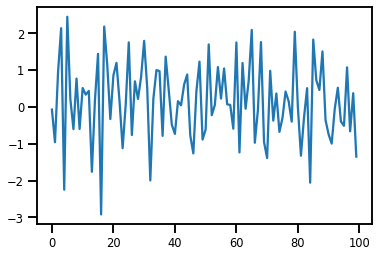

In [104]:
df.T[0].plot()

That's pretty unstable, but it shows the randomness present in each of the random draws (as well as the constant variance -- note the range of the predictions doesn't seem to change from the first draw to the last.

Let's plot the mean of all 1,000 draws for each input _x_ as well.

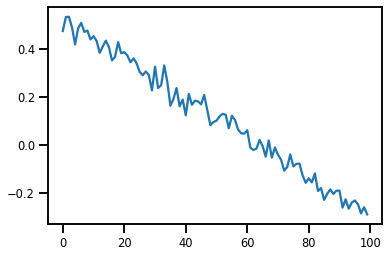

In [105]:
df.mean().plot()

Much better - the mean of the predicted data increases linearly with the size of the input. This matches our intuition.

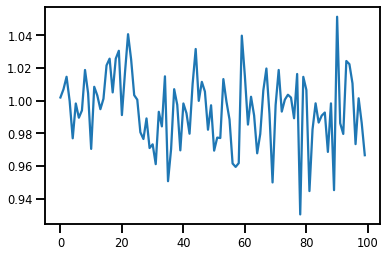

In [106]:
df.std().plot()

However, as we noted earlier, the standard deviation doesn't seem to change. It looks like it's mostly homoskedastic. Let's check this out, compared to the actual data.

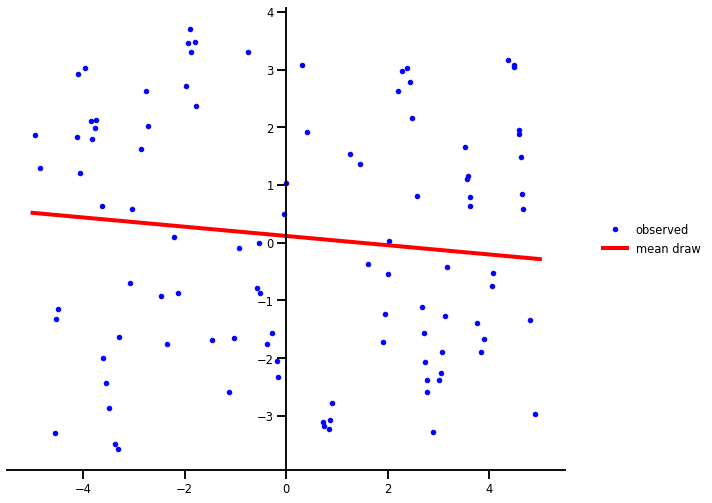

In [107]:
w = np.squeeze(model.layers[-2].kernel.numpy())
b = np.squeeze(model.layers[-2].bias.numpy())

plt.figure(figsize=[10, 8.5])
plt.plot(x, y, 'b.', label='observed');
plt.plot(x_tst, yhat.mean(),'r', label='mean draw', linewidth=4);
#plt.ylim(-0.,17);
#plt.yticks(np.linspace(0, 15, 4)[1:]);
#plt.xticks(np.linspace(*x_range, num=9));

ax = plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

This looks like an ok model (and it's about as far as we can go with traditional linear regression for these input data), but it's clear that we actually should have a lot _more_ uncertainty as the magnitudes of our input _x_'s increase. 

In [68]:
%%HTML
<iframe src="https://towardsdatascience.com/assumptions-of-linear-regression-algorithm-ed9ea32224e1" width="1200" height="1000"></iframe>


Fortunately, TensorFlow Probability allows us to be more flexible than most traditional formulations of linear regression.

In [108]:
# Build model.
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(1 + 1),  # Output two floats now, instead of just one.
        tfp.layers.DistributionLambda(
            lambda t: tfd.Normal(
                loc=t[..., :1],
                scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:])  # Fit the standard deviation to the second term
            )
        ),
    ]
)


# Due to TensorFlow 2.0 Eager semantics, we can use `negloglik` directly as our loss function.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
history = model.fit(
    x, 
    y, 
    epochs=1000, 
    validation_split=0.2, 
    verbose=0,
    callbacks=[PrintDot()]
)


yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Let's sample again from our output distribution from calling the model using our `x_tst` data set.

In [109]:
tensor_draw = yhat.sample(1000)
pd.DataFrame(tensor_draw.numpy().squeeze())

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2.693774,-0.346464,-1.258219,0.800870,-0.825105,-0.794349,-0.709468,-0.418958,1.247275,1.406632,...,1.630381,1.358692,-1.578539,2.370399,-1.430241,-0.748474,0.397965,-0.517467,0.749365,0.423045
1,-0.470015,1.999925,0.653586,1.265638,-0.847920,-1.222233,0.919095,-0.942564,-0.731872,1.225976,...,0.690612,0.633490,-0.754980,0.253937,0.136920,0.305088,0.189149,1.082093,1.117244,-0.675108
2,1.518295,-1.423516,-2.058131,-1.390130,-0.094524,-2.084158,2.584558,1.474067,-0.932044,-1.447038,...,1.842877,-0.473500,-0.585131,0.055807,0.217828,-0.138402,-0.156314,-0.968944,-0.251782,1.194920
3,-1.802045,-0.673874,1.206232,-1.923674,0.131650,0.155936,-1.657034,1.305315,0.136493,2.492933,...,-1.624652,-0.948505,0.065133,-0.500389,1.186914,-0.658417,-0.121740,0.387741,-0.555904,2.130745
4,0.546413,0.195427,2.798404,1.502868,-2.133474,1.120130,-0.561682,0.206904,-1.793992,-1.601067,...,-1.108559,0.052836,-1.359299,-2.369615,1.152906,-0.608579,0.546642,-0.304222,-0.400820,2.481030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.492030,0.192680,2.520004,0.090861,-1.465224,-0.751056,0.339627,-0.201979,-1.943869,1.483363,...,0.730688,-1.863931,1.821293,-0.710641,0.537605,-1.778180,-0.043371,0.140585,-2.231528,0.498618
996,2.106005,-1.962114,0.689337,2.293544,-0.177777,0.952330,-0.993223,-2.492044,0.240275,0.763150,...,-1.902398,-0.103093,1.140046,-0.638656,-0.150855,1.069985,-0.220541,-1.466258,1.433473,1.015246
997,3.037368,-0.292567,-0.877244,-0.882948,0.225436,-0.228800,1.177789,-0.307642,-1.050209,2.385816,...,-2.531205,0.106459,-1.694378,0.942839,0.076029,-0.636097,-0.044366,-0.040400,-0.636392,1.949190
998,0.343363,3.497165,3.049525,3.195000,0.557973,0.426072,0.181718,-0.149642,0.009672,1.622852,...,-1.470710,-1.432467,0.193938,0.597016,-0.949573,-1.167728,0.182785,-3.042792,1.356341,0.379033


And plot the mean, as before.

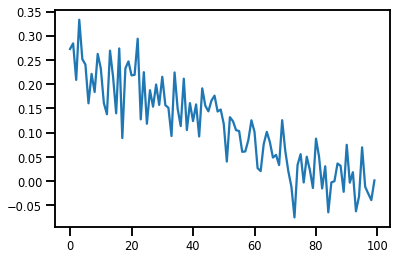

In [110]:
df = pd.DataFrame(tensor_draw.numpy().squeeze())
df.mean().plot()

The mean looks the same as before, maybe a little more wiggly as we get to the higher _x_'s -- that's good.

How about the standard deviations?

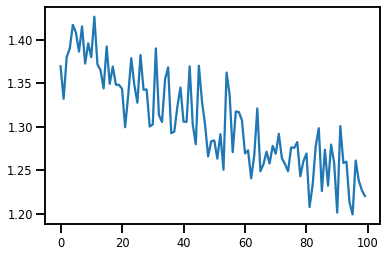

In [111]:
df.std().plot()

And, we've captured the heteroskedasticity present in our model now! Standard deviation in the distribution that describes the observed random variable appears to be increasing almost linearly with the random variable itself.

In [112]:
df[0].std(), df[50].std()#, df[100].std(), df[149].std()

(1.3694405555725098, 1.2841256856918335)

Let's plot to confirm.

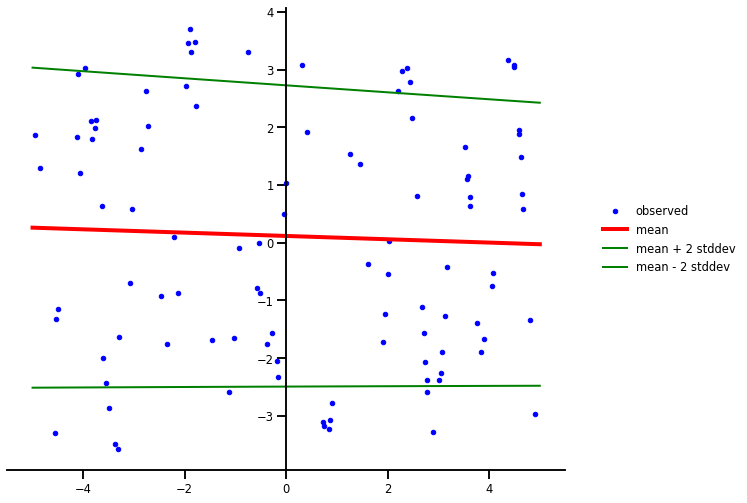

In [113]:
plt.figure(figsize=[10, 8.5])
plt.plot(x, y, 'b.', label='observed');

m = yhat.mean()
s = yhat.stddev()

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');  # +2 standard deviations
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');  # -2 standard deviations

#plt.ylim(-0.,17);
#plt.yticks(np.linspace(0, 15, 4)[1:]);
#plt.xticks(np.linspace(*x_range, num=9));

ax = plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig2.png', bbox_inches='tight', dpi=300)

Great! We've appropriately indicated that there's more _variance_ in the model's predictions as it gets further away from zero.

This sort of uncertainty is called __aleatoric uncertainty__ -- that is, uncertainty due to the problem itself.

In [114]:
%%HTML
<iframe src="https://en.wikipedia.org/wiki/Uncertainty_quantification#Aleatoric_and_epistemic_uncertainty" width="900" height="500"></iframe>

## Specifying uncertainty in the model slope

We've outlined how to capture uncertainty in the model outputs due to the behavior of the data, but what about uncertainty in the model's definition itself? In order to do this, we'll need to replace our previous _Dense_ layer with a _Dense Variational_ layer, using TensorFlow Probability Distributions' nice feature of interoperability with Keras.

This is very similar to the previous `DenseVariational` layer we used in the last example.

In [115]:
def posterior_mean_field(kernel_size: int, bias_size: Optional[int] = 0, dtype: Optional[str] = None) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])


def prior_trainable(kernel_size: int, bias_size: Optional[int] = 0, dtype: Optional[str] = None) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
    ])

This time, we won't be modeling the aleatoric uncertainty in the model predictions (specified by the distribution standard deviation), but instead focus strictly on the _epistemic_ uncertainty we have in the model's specification.

In [116]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, make_posterior_fn=posterior_mean_field, make_prior_fn=prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),  # Revert back to previous lambda.
])


model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False, callbacks=[PrintDot()])

yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Remember, every time we make a prediction, we'll be defining a new `Distribution` whose mean is our expected slope value for the linear model.

In [117]:
yhats = [model(x_tst) for _ in range(100)]  # Generate a lot of predictions for each x value.

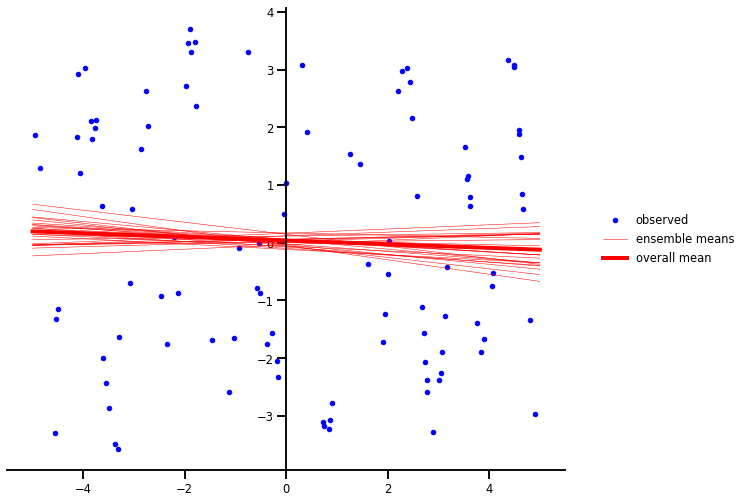

In [118]:
plt.figure(figsize=[10, 8.5])
plt.clf();
plt.plot(x, y, 'b.', label='observed');

avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())  # Randomly-drawn slope value.
    if i < 25:  # Only plot the first 25 mean slope values
        plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=0.5)
    avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

#plt.ylim(-0.,17);
#plt.yticks(np.linspace(0, 15, 4)[1:]);
#plt.xticks(np.linspace(*x_range, num=9));

ax = plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig3.png', bbox_inches='tight', dpi=300)

This is great! Now we can show the _range_ of slopes that are potentially available to our model, rather than a simple point estimate for one of them.

Note especially that, not only are we showing uncertainty as we move away from zero in the positive direction, but _also_ as we move away from zero in the negative direction.

In [119]:
tensor_draw = yhat.sample(1000)
pd.DataFrame(tensor_draw.numpy().reshape(1000, 150))

ValueError: cannot reshape array of size 100000 into shape (1000,150)

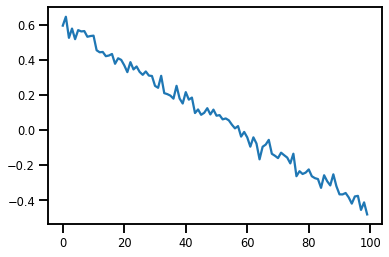

In [120]:
df = pd.DataFrame(tensor_draw.numpy().squeeze())
df.mean().plot()

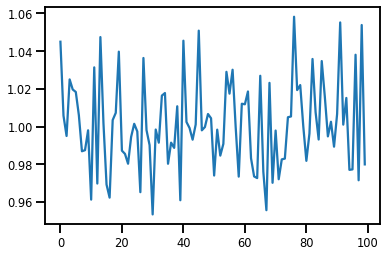

In [121]:
df.std().plot()

## Aleatoric _and_ epistemic uncertainty

A natural question when we've modeled each of aleatoric and epistemic uncertainty is, could we model them both simultaneously?

Of course we can! Just as before, we can tack another output onto the `Dense` (now `DenseVariational`) layer, and use that second output to model the standard deviation of the distribution being fit to the model's outputs.

In [122]:
model = tf.keras.Sequential(
    [
        tfp.layers.DenseVariational(
            1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]
        ),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Normal(
                loc=t[..., :1],
                scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
            )
        ),
    ]
)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False, callbacks=[PrintDot()])

yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

You might ask, how does this work, if the output of a `DenseVariational` layer is a distribution and not a float? How can `keras` pass a distribution to a parameterize a distribution?

The answer here is that typically, yes, the `DenseVariational` layer outputs a `tensorflow_probability` `Distribution` object; however, due to the first-class integration of TensorFlow Probability and TensorFlow 2.0 Keras, the model can recognize that the next layer expects a float and draw one from its distribution when called. 

We actually did this in the previous notebook when we subbed in a `DenseVariational` layer for the _first_ of two `Dense` layers and let it feed into the next `Dense` layer transparently. That's the magic of TensorFlow Probability and TensorFlow Keras.

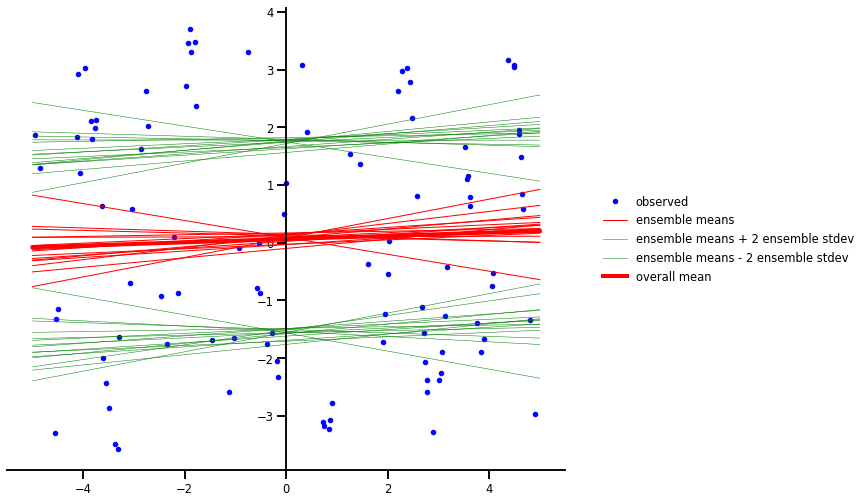

In [125]:
plt.figure(figsize=[10, 8.5])
plt.plot(x, y, 'b.', label='observed');

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])



yhat0 = yhats[0]
#print(yhat0)
#print(yhat0.mean())
#print(yhat0.stddev())

yhat1 = yhats[1]
#print(yhat0)
#print(yhat0.mean())
#print(yhat1.stddev())

model_s = []
for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
    model_s.append([s])
    if i < 15:
        plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
        plt.plot(x_tst, m + 2 * s, 'g', linewidth=0.5, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
        plt.plot(x_tst, m - 2 * s, 'g', linewidth=0.5, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
    avgm += m
#print(np.mean(model_s,axis = 0))

plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

#plt.ylim(-0.,17);
#plt.yticks(np.linspace(0, 15, 4)[1:]);
#plt.xticks(np.linspace(*x_range, num=9));

ax = plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig4.png', bbox_inches='tight', dpi=300)

Compared to the prior model that strictly considered aleatoric uncertainty, we're now able to capture the heteroskedasticity on _both_ sides of zero. Earlier, we only had one estimate of the standard deviation over model outputs coming from a single instantiated `Dense` layer, and the linear relationship favored the more obvious aleatoric uncertainty to the far positive end of the training data set. Once we instead set the model to draw from a distribution of reasonable standard deviations in epistemic fashion, we're able to capture the aleatoric uncertainty on either side of the y-axis.

## Takeaways

- There are two types of uncertainty that we're concerned with in probabilistc modeling:
  - **Epistemic** uncertainty, which is due to our knowledge of the problem
  - **Aleatoric** uncertainty, which is due to the problem itself
- TensorFlow Probability allows us to reason about either or both of these uncertainty types by parameterizing distributions over model outputs and model weights.
- We can use traditional `keras` layers to parameterize TensorFlow Probability `distributions` and select sensible distributions for the problem at-hand.

## References

Once again, this material was adapted from the blog post [Regression with Probabilistic Layers in TensorFlow Probability](https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf), by the TFP team. Everyone is encouraged to check it out firsthand. There is a big reveal at the end that we did not spoil in this notebook.

Additionally, Josh Dillon, a senior member of the TFP team, gave a talk on TensorFlow Probability at the TensorFlow Dev Summit this year highlighting this problem and other high-level features of the library. Please check it out!

In [44]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/BrwKURU-wpk" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')


/Users/zach_anglin/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
